# Citi Bike × NYPD: Usage patterns + insurer decision assets

This notebook is built to work with the repo Make targets (e.g. `make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"`).

It **always prefers the current run** (your `summaries/<RUN_TAG>/` folder) when you pass `YEARS/MONTHS`, so the report reflects exactly what you ingested.


## How to run (recommended)

From the repo root:

```bash
make all MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
```

The Makefile sets environment variables (e.g. `CITIBIKE_PARQUET_DIR`, `CITIBIKE_YEARS`, `CITIBIKE_MONTHS`) which this notebook reads.


In [1]:
# --- Setup (STRICT): locate repo, resolve RUN_DIR + PARQUET_DIR, load summaries safely ---
from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display, Markdown
    _HAVE_IPYTHON = True
except Exception:
    display = print
    Markdown = lambda x: x
    _HAVE_IPYTHON = False

# Ensure figures render into the executed notebook outputs
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

plt.ioff()  # nbconvert-friendly (prevents interactive windows)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Makefile").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
SUMMARIES_ROOT = REPO_ROOT / "summaries"

def _parse_int_list(val: str | None):
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    parts = re.split(r"[,\s]+", s)
    out = []
    for p in parts:
        if not p:
            continue
        try:
            out.append(int(p))
        except Exception:
            pass
    return out or None

# Inputs from Makefile (recommended)
PARQUET_DIR_ENV = (os.environ.get("CITIBIKE_PARQUET_DIR") or "").strip()
RUN_DIR_ENV     = (os.environ.get("CITIBIKE_RUN_DIR") or "").strip()
MODE_ENV        = (os.environ.get("CITIBIKE_MODE") or os.environ.get("MODE") or "").strip().lower()

YEARS_FILTER  = _parse_int_list(os.environ.get("CITIBIKE_YEARS")  or os.environ.get("YEARS"))
MONTHS_FILTER = _parse_int_list(os.environ.get("CITIBIKE_MONTHS") or os.environ.get("MONTHS"))

PARQUET_DIR = Path(PARQUET_DIR_ENV) if PARQUET_DIR_ENV else Path()
if RUN_DIR_ENV:
    RUN_DIR = Path(RUN_DIR_ENV)
else:
    # Infer RUN_TAG from parquet folder name; expects .../citibike_parquet/<RUN_TAG>
    run_tag = PARQUET_DIR.name if str(PARQUET_DIR).strip() else ""
    RUN_DIR = SUMMARIES_ROOT / run_tag if run_tag else Path()

# Resolve relative -> absolute (relative to REPO_ROOT)
if RUN_DIR and (not RUN_DIR.is_absolute()):
    RUN_DIR = (REPO_ROOT / RUN_DIR).resolve()
if PARQUET_DIR and (not PARQUET_DIR.is_absolute()):
    PARQUET_DIR = (REPO_ROOT / PARQUET_DIR).resolve()

# ---- STRICT checks ----
if not (REPO_ROOT / "Makefile").exists():
    raise FileNotFoundError(
        f"Expected to find repo root (Makefile) by walking up from CWD.\n"
        f"  CWD: {Path.cwd().resolve()}\n"
        f"  Derived REPO_ROOT: {REPO_ROOT}"
    )

if not SUMMARIES_ROOT.exists():
    raise FileNotFoundError(
        f"Expected summaries/ folder not found at: {SUMMARIES_ROOT}\n"
        "Run: make summarize (or make all) first."
    )

if not RUN_DIR.exists():
    raise FileNotFoundError(
        f"Expected summaries run_dir not found:\n  {RUN_DIR}\n"
        "Run: make summarize (or make all) first."
    )

if not PARQUET_DIR.exists():
    raise FileNotFoundError(
        f"Expected parquet dir not found:\n  {PARQUET_DIR}\n"
        "Run: make ingest (or make all) first."
    )

REQUIRED_RUN_FILES = [
    "citibike_trips_by_year.csv",
    "citibike_trips_by_month.csv",
    "citibike_trips_by_dow.csv",
    "citibike_trips_by_hour.csv",
]
missing = [f for f in REQUIRED_RUN_FILES if not (RUN_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        "Missing required summary CSVs in run_dir:\n"
        f"  {RUN_DIR}\n"
        f"Missing: {missing}\n"
        "Run: make summarize (or make all) first."
    )

print("REPO_ROOT:", REPO_ROOT)
print("PARQUET_DIR:", PARQUET_DIR)
print("RUN_DIR:", RUN_DIR)
print("MODE (env):", MODE_ENV or "(not set)")
print("YEARS_FILTER:", YEARS_FILTER, "MONTHS_FILTER:", MONTHS_FILTER)

# Where to save figures (also show inline)
FIG_DIR = REPO_ROOT / "reports" / RUN_DIR.name / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)

def savefig(filename: str):
    out = FIG_DIR / filename
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

def read_csv(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

# ---- Load per-run summary CSVs ----
df_year  = read_csv(RUN_DIR / "citibike_trips_by_year.csv")
df_month = read_csv(RUN_DIR / "citibike_trips_by_month.csv")
df_dow   = read_csv(RUN_DIR / "citibike_trips_by_dow.csv")
df_hour  = read_csv(RUN_DIR / "citibike_trips_by_hour.csv")

# Optional per-run outputs
station_path = RUN_DIR / "citibike_station_exposure.csv"
df_station = read_csv(station_path) if station_path.exists() else None

risk_path = RUN_DIR / "station_risk_exposure_plus_crashproximity.csv"
df_risk = read_csv(risk_path) if risk_path.exists() else None

highlights_path = RUN_DIR / "summary_highlights.md"

# Mode detection (prefer data, else env)
mode = (
    str(df_year["mode"].iloc[0]).lower()
    if ("mode" in df_year.columns and len(df_year))
    else (MODE_ENV or "unknown")
)
print("Detected mode:", mode)

# ---- Compare tables (optional) ----
# If YEARS/MONTHS filters are passed (e.g., Jan–Mar), we default to THIS run only.
USE_COMPARE = (YEARS_FILTER is None and MONTHS_FILTER is None)
COMPARE_DIR = SUMMARIES_ROOT / "_compare"

def _maybe_load_compare(fname: str) -> pd.DataFrame | None:
    p = COMPARE_DIR / fname
    return read_csv(p) if p.exists() else None

if USE_COMPARE and COMPARE_DIR.exists():
    df_year_all  = _maybe_load_compare("citibike_trips_by_year_ALL.csv")  or df_year.copy()
    df_month_all = _maybe_load_compare("citibike_trips_by_month_ALL.csv") or df_month.copy()
    df_dow_all   = _maybe_load_compare("citibike_trips_by_dow_ALL.csv")   or df_dow.copy()
    df_hour_all  = _maybe_load_compare("citibike_trips_by_hour_ALL.csv")  or df_hour.copy()
else:
    df_year_all, df_month_all, df_dow_all, df_hour_all = df_year.copy(), df_month.copy(), df_dow.copy(), df_hour.copy()

# Always filter _ALL tables to current mode (if they have a mode column)
for _name in ["df_year_all", "df_month_all", "df_dow_all", "df_hour_all"]:
    _df = locals()[_name]
    if isinstance(_df, pd.DataFrame) and ("mode" in _df.columns):
        locals()[_name] = _df[_df["mode"].astype(str).str.lower() == mode].copy()

# If filters are provided, enforce them on the per-run tables too (defensive)
def _filter_year_month(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if YEARS_FILTER is not None and "year" in out.columns:
        out["year"] = pd.to_numeric(out["year"], errors="coerce")
        out = out[out["year"].isin(YEARS_FILTER)]
    if MONTHS_FILTER is not None and "month" in out.columns:
        out["month"] = pd.to_numeric(out["month"], errors="coerce")
        out = out[out["month"].isin(MONTHS_FILTER)]
    return out

df_year  = _filter_year_month(df_year)
df_month = _filter_year_month(df_month)
df_dow   = _filter_year_month(df_dow)
df_hour  = _filter_year_month(df_hour)

# Helpful run label for titles
run_label = RUN_DIR.name


REPO_ROOT: /home/maral/Desktop/citibike-insurance-challenge
PARQUET_DIR: /home/maral/Desktop/citibike-insurance-challenge/data/processed/citibike_parquet/y2018_2020_m1_2_3_modejc
RUN_DIR: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2018_2020_m1_2_3_modejc
MODE (env): jc
YEARS_FILTER: [2018, 2020] MONTHS_FILTER: [1, 2, 3]
FIG_DIR: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures
Detected mode: jc


## Executive summary (optional)

If you generated `summary_highlights.md` for this run, we show it here.


In [2]:
# --- Quick text highlights from summarize script (if present) ---
if highlights_path.exists():
    txt = highlights_path.read_text(encoding="utf-8", errors="ignore")
    display(Markdown(txt))
else:
    print("No summary_highlights.md found at:", highlights_path)


# Summary highlights

- Mode filter: `jc`

## Top years for mode=jc
- **2020**: 66,701 trips (59.77% of mode)
- **2018**: 44,890 trips (40.23% of mode)

## Top months for mode=jc
- **2020-01**: 26,020 trips (23.32% of mode), trips/day=839.4
- **2020-02**: 22,962 trips (20.58% of mode), trips/day=791.8
- **2020-03**: 17,719 trips (15.88% of mode), trips/day=571.6
- **2018-03**: 17,109 trips (15.33% of mode), trips/day=551.9
- **2018-02**: 15,104 trips (13.54% of mode), trips/day=539.4
- **2018-01**: 12,677 trips (11.36% of mode), trips/day=408.9

## Top days-of-week for mode=jc (overall, all years)
- **Tuesday**: 18,378 trips (16.47% of mode)
- **Wednesday**: 18,169 trips (16.28% of mode)
- **Thursday**: 17,717 trips (15.88% of mode)
- **Monday**: 17,150 trips (15.37% of mode)
- **Friday**: 16,712 trips (14.98% of mode)

## Top days-of-week for mode=jc (weekday, all years)
- **Tuesday**: 18,378 trips (20.85% of weekday)
- **Wednesday**: 18,169 trips (20.62% of weekday)
- **Thursday**: 17,717 trips (20.10% of weekday)
- **Monday**: 17,150 trips (19.46% of weekday)
- **Friday**: 16,712 trips (18.96% of weekday)

## Top days-of-week for mode=jc (weekend, all years)
- **Saturday**: 12,384 trips (52.78% of weekend)
- **Sunday**: 11,081 trips (47.22% of weekend)

## Top 5 hours for mode=jc (by trips, all years)
### weekday
- **08:00**: 11,759 trips (13.34% of weekday)
- **18:00**: 10,486 trips (11.90% of weekday)
- **17:00**: 9,776 trips (11.09% of weekday)
- **07:00**: 7,247 trips (8.22% of weekday)
- **19:00**: 6,369 trips (7.23% of weekday)
### weekend
- **15:00**: 2,130 trips (9.08% of weekend)
- **13:00**: 2,116 trips (9.02% of weekend)
- **14:00**: 1,993 trips (8.49% of weekend)
- **16:00**: 1,950 trips (8.31% of weekend)
- **12:00**: 1,924 trips (8.20% of weekend)



## 1) Yearly usage (comparison across years)

,mode,year,trips,yoy_pct
0,jc,2018,44890,NaN
1,jc,2020,66701,48.587659


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/01_trips_by_year.png


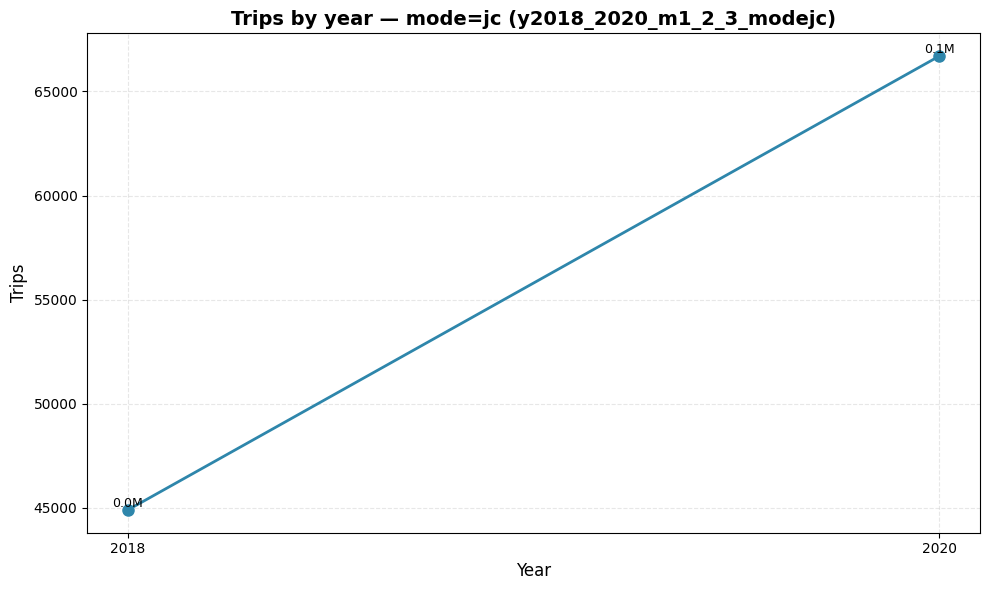

In [3]:
# --- Trips by year (THIS RUN) ---
g = df_year.copy()

if "year" in g.columns:
    # Clean and prepare data
    g["year"] = pd.to_numeric(g["year"], errors="coerce")
    g = g.dropna(subset=["year"]).sort_values("year").reset_index(drop=True)
    
display(g)

# Plot
plt.figure(figsize=(10, 6))

if "year" in g.columns and "trips" in g.columns:
    # Extract values as plain lists (no pandas magic)
    years = [int(y) for y in g["year"]]
    trips = [int(t) for t in g["trips"]]
    
    # Plot with explicit year labels
    plt.plot(years, trips, marker="o", linewidth=2, markersize=8, color='#2E86AB')
    plt.xticks(years, [str(y) for y in years])  # Explicit year labels
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add value labels on points
    for year, trip in zip(years, trips):
        plt.text(year, trip, f'{trip/1e6:.1f}M', 
                ha='center', va='bottom', fontsize=9)

plt.title(f"Trips by year — mode={mode} ({run_label})", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Trips", fontsize=12)
plt.tight_layout()

savefig("01_trips_by_year.png")
plt.show()


## 2) Month patterns (comparison)

,mode,year,month,trips,active_days,trips_per_day
0,jc,2018,1,12677,31,408.935484
1,jc,2018,2,15104,28,539.428571
2,jc,2018,3,17109,31,551.903226
3,jc,2020,1,26020,31,839.354839
4,jc,2020,2,22962,29,791.793103
5,jc,2020,3,17719,31,571.580645


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/02_trips_by_year_month.png


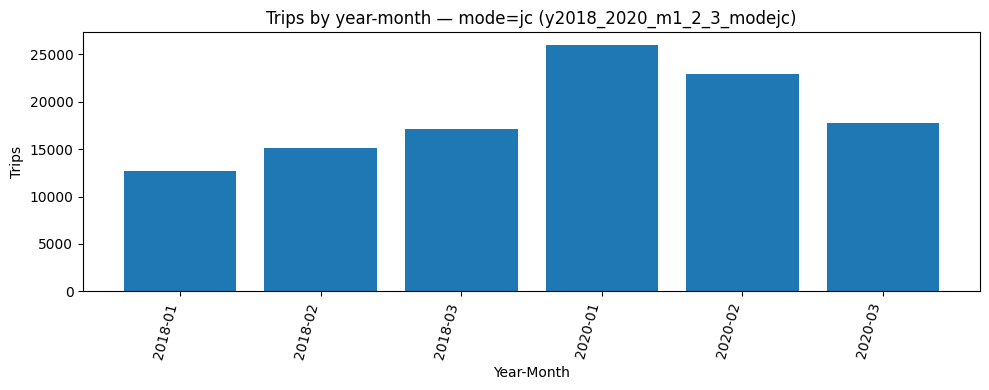

In [4]:
# --- Trips by month (THIS RUN) ---
m = df_month.copy()

# Normalize month labels
if "month" in m.columns:
    m["month"] = pd.to_numeric(m["month"], errors="coerce").astype("Int64")
if "year" in m.columns:
    m["year"] = pd.to_numeric(m["year"], errors="coerce").astype("Int64")

display(m.sort_values([c for c in ["year", "month"] if c in m.columns]))

# If multiple years, show stacked-ish bars by year-month
if {"year", "month", "trips"}.issubset(m.columns):
    m2 = m.dropna(subset=["year","month"]).copy()
    m2["ym"] = m2["year"].astype(int).astype(str) + "-" + m2["month"].astype(int).astype(str).str.zfill(2)

    plt.figure(figsize=(10,4))
    plt.bar(m2["ym"], m2["trips"])
    plt.title(f"Trips by year-month — mode={mode} ({run_label})")
    plt.xlabel("Year-Month")
    plt.ylabel("Trips")
    plt.xticks(rotation=75, ha="right")
    plt.tight_layout()
    savefig("02_trips_by_year_month.png")
    plt.show()
else:
    print("Expected columns not present for trips-by-month plot. Have:", list(m.columns))


year,2018,2020
month,,
1,12677,26020
2,15104,22962
3,17109,17719


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/03_month_by_year_lines.png


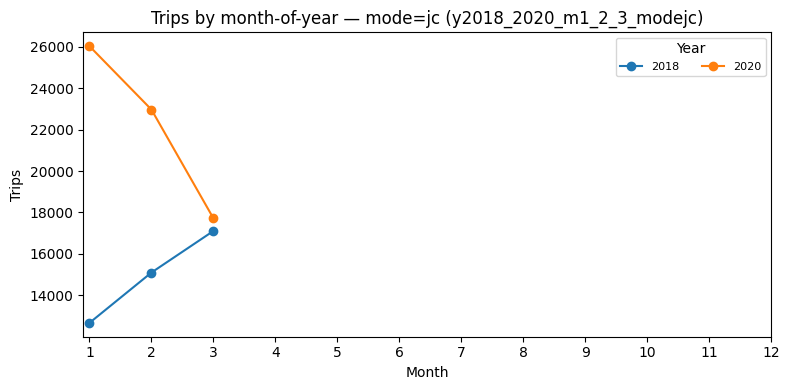

In [5]:
# --- Month-of-year seasonality (line chart per year) ---
m = df_month.copy()
if not {"year","month","trips"}.issubset(m.columns):
    print("Month table missing required columns:", list(m.columns))
else:
    m["year"]  = pd.to_numeric(m["year"], errors="coerce").astype("Int64")
    m["month"] = pd.to_numeric(m["month"], errors="coerce").astype("Int64")
    m = m.dropna(subset=["year","month"]).copy()
    m = m.sort_values(["year","month"])

    pivot = m.pivot_table(index="month", columns="year", values="trips", aggfunc="sum").sort_index()
    display(pivot)

    plt.figure(figsize=(8,4))
    for y in pivot.columns:
        plt.plot(pivot.index.astype(int), pivot[y], marker="o", label=str(int(y)))
    plt.title(f"Trips by month-of-year — mode={mode} ({run_label})")
    plt.xlabel("Month")
    plt.ylabel("Trips")
    plt.xticks(range(1,13))
    plt.legend(title="Year", ncol=2, fontsize=8)
    plt.tight_layout()
    savefig("03_month_by_year_lines.png")
    plt.show()


## 3) Day-of-week patterns (comparison)

,mode,year,dow,dow_name,week_part,trips,pct_of_mode_year_trips,pct_within_week_part
0,jc,2018,0,Monday,weekday,7631,16.999332,21.193101
1,jc,2018,1,Tuesday,weekday,8006,17.834707,22.234566
2,jc,2018,2,Wednesday,weekday,7088,15.789708,19.685061
3,jc,2018,3,Thursday,weekday,6896,15.361996,19.151832
4,jc,2018,4,Friday,weekday,6386,14.225885,17.735440
5,jc,2018,5,Saturday,weekend,5239,11.670751,58.977823
6,jc,2018,6,Sunday,weekend,3644,8.117621,41.022177
7,jc,2020,0,Monday,weekday,9519,14.271150,18.263973
8,jc,2020,1,Tuesday,weekday,10372,15.549992,19.900612
9,jc,2020,2,Wednesday,weekday,11081,16.612944,21.260960


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/04_trips_by_dow.png


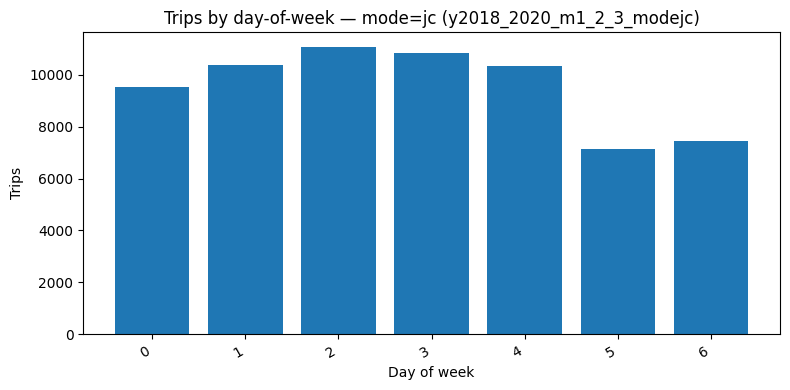

In [6]:
# --- Trips by day-of-week (THIS RUN) ---
d = df_dow.copy()
display(d)

# Prefer an ordered weekday axis if possible
if "dow" in d.columns:
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    d["dow"] = d["dow"].astype(str)
    if set(order).issubset(set(d["dow"].unique())):
        d["dow"] = pd.Categorical(d["dow"], categories=order, ordered=True)
        d = d.sort_values("dow")

if {"dow","trips"}.issubset(d.columns):
    plt.figure(figsize=(8,4))
    plt.bar(d["dow"].astype(str), d["trips"])
    plt.title(f"Trips by day-of-week — mode={mode} ({run_label})")
    plt.xlabel("Day of week")
    plt.ylabel("Trips")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    savefig("04_trips_by_dow.png")
    plt.show()
else:
    print("Day-of-week table missing required columns. Have:", list(d.columns))


## 4) Hour-of-day patterns (comparison)

,mode,year,hour,week_part,trips,pct_of_mode_year_trips,pct_within_week_part
0,jc,2018,0,weekday,219,0.487859,0.608215
1,jc,2018,0,weekend,147,0.327467,1.654846
2,jc,2018,1,weekday,106,0.236133,0.294387
3,jc,2018,1,weekend,112,0.249499,1.260835
4,jc,2018,2,weekday,36,0.080196,0.099981
5,jc,2018,2,weekend,45,0.100245,0.506586
6,jc,2018,3,weekday,31,0.069058,0.086094
7,jc,2018,3,weekend,38,0.084651,0.427783
8,jc,2018,4,weekday,92,0.204945,0.255506
9,jc,2018,4,weekend,24,0.053464,0.270179


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/05_trips_by_hour.png


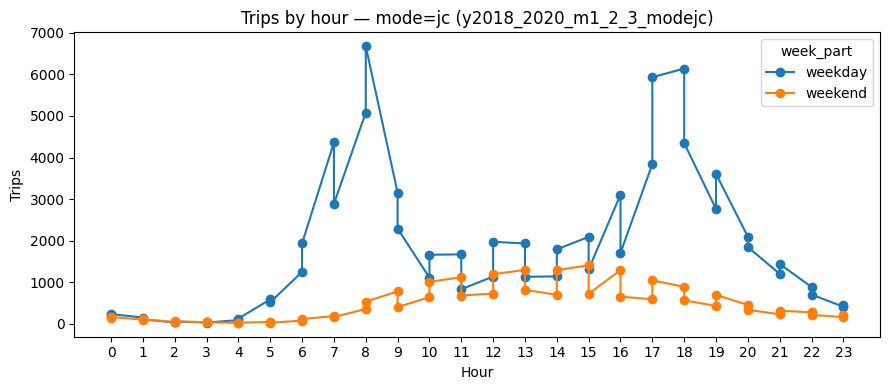

In [7]:
# --- Trips by hour (weekday vs weekend if present) ---
h = df_hour.copy()
display(h.head(20))

# Expect cols: hour, trips, week_part or segment
hour_col = "hour" if "hour" in h.columns else None
trips_col = "trips" if "trips" in h.columns else None
part_col = None
for c in ["week_part","segment","is_weekend"]:
    if c in h.columns:
        part_col = c
        break

if not (hour_col and trips_col):
    print("Hour table missing required columns. Have:", list(h.columns))
else:
    h[hour_col] = pd.to_numeric(h[hour_col], errors="coerce")
    h[trips_col] = pd.to_numeric(h[trips_col], errors="coerce")
    h = h.dropna(subset=[hour_col, trips_col]).sort_values(hour_col)

    if part_col:
        # Plot each segment as its own line
        plt.figure(figsize=(9,4))
        for seg, sub in h.groupby(part_col):
            sub = sub.sort_values(hour_col)
            plt.plot(sub[hour_col], sub[trips_col], marker="o", label=str(seg))
        plt.title(f"Trips by hour — mode={mode} ({run_label})")
        plt.xlabel("Hour")
        plt.ylabel("Trips")
        plt.xticks(range(0,24,1), rotation=0)
        plt.legend(title=part_col)
        plt.tight_layout()
        savefig("05_trips_by_hour.png")
        plt.show()
    else:
        plt.figure(figsize=(9,4))
        plt.plot(h[hour_col], h[trips_col], marker="o")
        plt.title(f"Trips by hour — mode={mode} ({run_label})")
        plt.xlabel("Hour")
        plt.ylabel("Trips")
        plt.xticks(range(0,24,1), rotation=0)
        plt.tight_layout()
        savefig("05_trips_by_hour.png")
        plt.show()


## 5) Station exposure (optional)

,mode,year,month,station_id,station_name,trips,start_trips,end_trips,touchpoints,station_lat,station_lng
170,jc,2020,1,3186,Grove St PATH,6648,3100,3548,6648,40.719586,-74.043117
223,jc,2020,2,3186,Grove St PATH,5437,2328,3109,5437,40.719586,-74.043117
114,jc,2018,3,3186,Grove St PATH,4802,2239,2563,4802,40.719586,-74.043117
56,jc,2018,2,3186,Grove St PATH,4404,2074,2330,4404,40.719586,-74.043117
0,jc,2018,1,3186,Grove St PATH,3632,1716,1916,3632,40.719586,-74.043117
277,jc,2020,3,3186,Grove St PATH,2978,1335,1643,2978,40.719586,-74.043117
171,jc,2020,1,3195,Sip Ave,2803,1493,1310,2803,40.730897,-74.063913
224,jc,2020,2,3195,Sip Ave,2744,1402,1342,2744,40.730897,-74.063913
172,jc,2020,1,3203,Hamilton Park,2669,1327,1342,2669,40.727596,-74.044247
173,jc,2020,1,3792,Columbus Dr at Exchange Pl,2307,1152,1155,2307,40.716870,-74.032810


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/06_top_stations_exposure.png


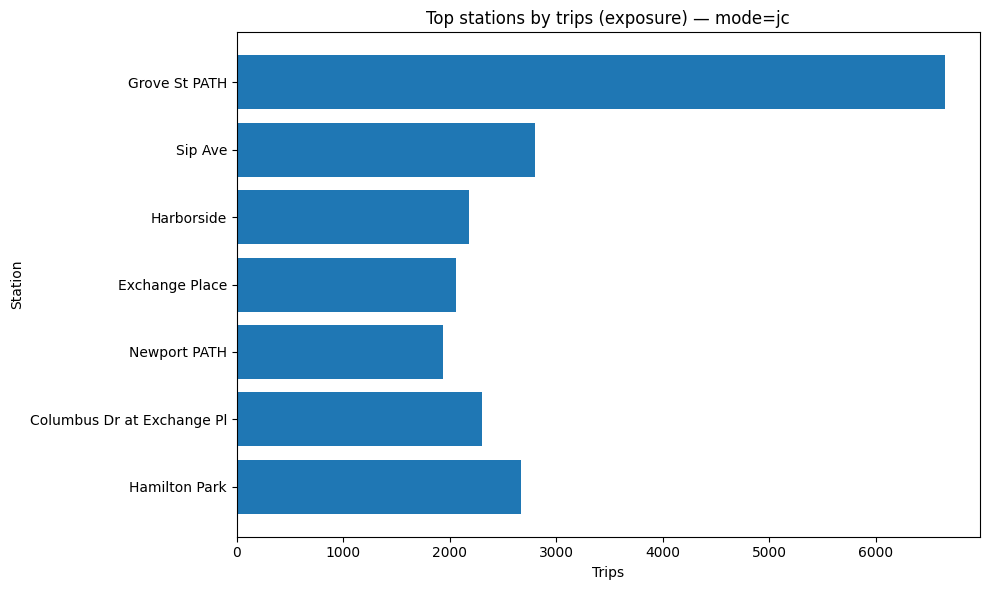

In [8]:
# --- Station exposure: where trips concentrate (policies / riders) ---
if df_station is None:
    print("No station exposure file found (citibike_station_exposure.csv). Skipping.")
else:
    s = df_station.copy()

    # Normalize column names across modes / scripts
    if "station_name" not in s.columns and "start_station_name" in s.columns:
        s = s.rename(columns={"start_station_name": "station_name"})
    if "station_id" not in s.columns and "start_station_id" in s.columns:
        s = s.rename(columns={"start_station_id": "station_id"})

    trips_col = "trips" if "trips" in s.columns else None
    name_col = "station_name" if "station_name" in s.columns else None

    if trips_col is None or name_col is None:
        print("Station exposure table missing required columns. Columns:", list(s.columns))
    else:
        s[trips_col] = pd.to_numeric(s[trips_col], errors="coerce")
        s = s.dropna(subset=[trips_col])
        top = s.sort_values(trips_col, ascending=False).head(20)
        display(top)

        plt.figure(figsize=(10,6))
        _tmp = top.iloc[::-1]  # nicer horizontal bars
        plt.barh(_tmp[name_col].astype(str), _tmp[trips_col])
        plt.title(f"Top stations by trips (exposure) — mode={mode}")
        plt.xlabel("Trips")
        plt.ylabel("Station")
        plt.tight_layout()
        savefig("06_top_stations_exposure.png")
        plt.show()


## 6) Crash proximity / risk proxy (optional)

### 6.1 Station-level prioritization (make the proxy usable)

The raw file includes **crash counts within 250m/500m** of each station plus **trip volume**.  
To avoid misleading outliers (e.g., stations with only a handful of trips), we:

- keep IDs as **strings** (so `2231.10` doesn’t turn into `2231.1`)
- recompute crash-rates per 100k trips (defensive)
- rank **exposure** (most trips) separately from **risk rate** (filtered to stations with enough trips)

You can tune `MIN_TRIPS_FOR_RATE` depending on how conservative you want to be.


Diagnostic: lowest-trip stations -> raw per-100k rates explode (tiny denominator)


,mode,station_id,station_name,trips,crashes_within_250m,crashes_within_250m_per_100k_trips,crashes_within_500m,crashes_within_500m_per_100k_trips
68,jc,462,W 22 St & 10 Ave,1,0,0.0,0,0.0
69,jc,514,12 Ave & W 40 St,1,0,0.0,0,0.0
72,jc,537,Lexington Ave & E 24 St,1,0,0.0,0,0.0
73,jc,83,Atlantic Ave & Fort Greene Pl,1,0,0.0,0,0.0
70,jc,520,W 52 St & 5 Ave,1,0,0.0,0,0.0
65,jc,377,6 Ave & Canal St,1,0,0.0,0,0.0
0,jc,303,Mercer St & Spring St,2,0,0.0,0,0.0
1,jc,309,Murray St & West St,2,0,0.0,0,0.0
55,jc,3541,Amsterdam Ave & W 125 St,2,0,0.0,0,0.0
71,jc,525,W 34 St & 11 Ave,2,0,0.0,0,0.0


Top 20 stations by exposure (trips) — stable only (trips ≥ 5000)


,mode,station_id,station_name,trips
5,jc,3186,Grove St PATH,27901
21,jc,3203,Hamilton Park,12387
14,jc,3195,Sip Ave,12119
20,jc,3202,Newport PATH,9224
57,jc,3639,Harborside,8201
46,jc,3276,Marin Light Rail,6753
4,jc,3185,City Hall,6404
27,jc,3211,Newark Ave,6371
36,jc,3267,Morris Canal,6317
17,jc,3199,Newport Pkwy,6261


Top 20 stations by EB-smoothed crash proxy (250m) — stable only (trips ≥ 5000)


,mode,station_id,station_name,trips,crashes_within_250m,eb_rate_250m_per_100k_trips
2,jc,3183,Exchange Place,5729,0,0.0
3,jc,3184,Paulus Hook,5234,0,0.0
4,jc,3185,City Hall,6404,0,0.0
5,jc,3186,Grove St PATH,27901,0,0.0
6,jc,3187,Warren St,5486,0,0.0
14,jc,3195,Sip Ave,12119,0,0.0
17,jc,3199,Newport Pkwy,6261,0,0.0
20,jc,3202,Newport PATH,9224,0,0.0
21,jc,3203,Hamilton Park,12387,0,0.0
27,jc,3211,Newark Ave,6371,0,0.0


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/09_scatter_trips_vs_EB_crash_rate_trips_ge_5000.png


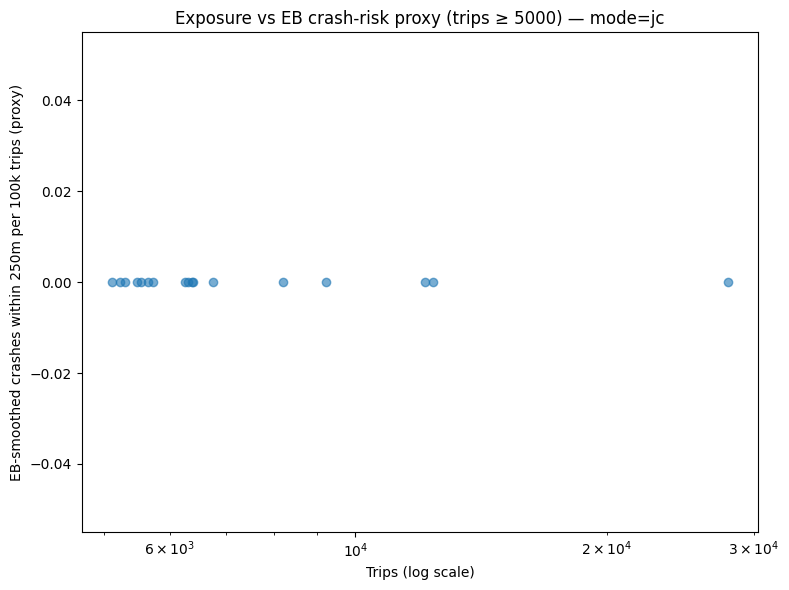

In [9]:
# --- Crash proximity risk proxy (NYC only): make it interpretable and usable ---
# NYPD "crashes within radius" is NOT "bike crashes". It's a *location safety proxy*.
# Raw "per-100k trips" rates can look insane when trips are tiny (tiny denominator).
# So:
#   - We show the low-trip explosion as a diagnostic (why the numbers look crazy)
#   - We ONLY rank by risk for stations with enough trips (MIN_TRIPS_FOR_RATE)
#   - We compute an Empirical Bayes (EB) smoothed rate to shrink noisy stations to the city baseline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MIN_TRIPS_FOR_RATE = 5000
TOP_N = 20
EB_M_PRIOR = 20000.0
SCALE = 100000.0

def eb_rate_per_trip(k: np.ndarray, e: np.ndarray, m_prior: float) -> np.ndarray:
    """EB smoothing for Poisson rate per trip: (k + r0*m)/(e+m), r0=sum(k)/sum(e)."""
    k = k.astype(float)
    e = e.astype(float)
    e_sum = float(np.nansum(e))
    r0 = float(np.nansum(k) / e_sum) if e_sum > 0 else 0.0
    return (k + r0 * m_prior) / (e + m_prior)

if df_risk is None:
    print("No station risk file found (station_risk_exposure_plus_crashproximity.csv). Skipping crash-proxy section.")
else:
    r = df_risk.copy()

    # Normalize ids/names (so downstream tables are stable)
    if "station_id" not in r.columns and "start_station_id" in r.columns:
        r = r.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in r.columns and "start_station_name" in r.columns:
        r = r.rename(columns={"start_station_name": "station_name"})

    # Numeric coercions
    for c in ["trips", "crashes_within_250m", "crashes_within_500m"]:
        if c in r.columns:
            r[c] = pd.to_numeric(r[c], errors="coerce")

    r = r.dropna(subset=["trips"]).copy()
    r = r[r["trips"] > 0].copy()

    # Defensive: if crash columns missing, create zeros (so notebook still runs)
    r["crashes_within_250m"] = pd.to_numeric(r.get("crashes_within_250m", 0), errors="coerce").fillna(0).astype(int)
    r["crashes_within_500m"] = pd.to_numeric(r.get("crashes_within_500m", 0), errors="coerce").fillna(0).astype(int)

    # Canonical raw rates (keep ONE naming scheme to avoid duplicates)
    r["crashes_within_250m_per_100k_trips"] = (r["crashes_within_250m"] / r["trips"]) * SCALE
    r["crashes_within_500m_per_100k_trips"] = (r["crashes_within_500m"] / r["trips"]) * SCALE

    print("Diagnostic: lowest-trip stations -> raw per-100k rates explode (tiny denominator)")
    display(
        r.sort_values("trips", ascending=True)
         .head(10)[[
            "mode","station_id","station_name","trips",
            "crashes_within_250m","crashes_within_250m_per_100k_trips",
            "crashes_within_500m","crashes_within_500m_per_100k_trips"
         ]]
    )

    # Stable subset for ranking
    stable = r[r["trips"] >= MIN_TRIPS_FOR_RATE].copy()
    if stable.empty:
        print(f"No stations with trips >= {MIN_TRIPS_FOR_RATE}. Risk ranking skipped.")
    else:
        # EB smoothed rates (per 100k trips)
        stable["eb_rate_250m_per_100k_trips"] = eb_rate_per_trip(
            stable["crashes_within_250m"].to_numpy(),
            stable["trips"].to_numpy(),
            EB_M_PRIOR,
        ) * SCALE
        stable["eb_rate_500m_per_100k_trips"] = eb_rate_per_trip(
            stable["crashes_within_500m"].to_numpy(),
            stable["trips"].to_numpy(),
            EB_M_PRIOR,
        ) * SCALE

        print(f"Top {TOP_N} stations by exposure (trips) — stable only (trips ≥ {MIN_TRIPS_FOR_RATE})")
        display(
            stable.sort_values("trips", ascending=False)
                  .head(TOP_N)[["mode","station_id","station_name","trips"]]
        )

        print(f"Top {TOP_N} stations by EB-smoothed crash proxy (250m) — stable only (trips ≥ {MIN_TRIPS_FOR_RATE})")
        display(
            stable.sort_values("eb_rate_250m_per_100k_trips", ascending=False)
                  .head(TOP_N)[["mode","station_id","station_name","trips","crashes_within_250m","eb_rate_250m_per_100k_trips"]]
        )

        # Quick plot: exposure vs EB risk (what you keep for interviews)
        plt.figure(figsize=(8, 6))
        plt.scatter(stable["trips"], stable["eb_rate_250m_per_100k_trips"], alpha=0.6)
        plt.xscale("log")
        plt.xlabel("Trips (log scale)")
        plt.ylabel("EB-smoothed crashes within 250m per 100k trips (proxy)")
        plt.title(f"Exposure vs EB crash-risk proxy (trips ≥ {MIN_TRIPS_FOR_RATE}) — mode={mode}")
        plt.tight_layout()
        savefig(f"09_scatter_trips_vs_EB_crash_rate_trips_ge_{MIN_TRIPS_FOR_RATE}.png")
        plt.show()


,stations
zone,
High exposure / High risk,9
Lower exposure / High risk,8


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/10_exposure_vs_risk_zones_trips_ge_5000.png


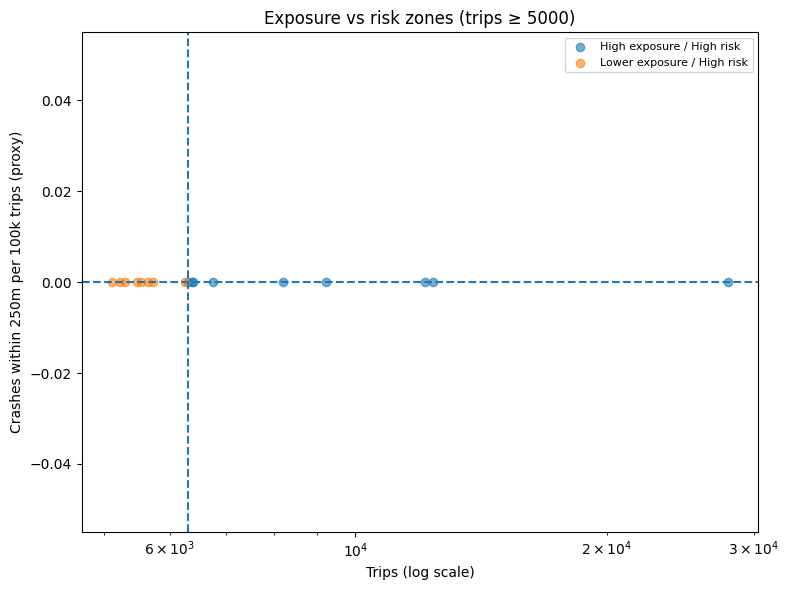

In [10]:
# --- Exposure vs Risk "Zones" (simple quadrant view) ---
import numpy as np

MIN_TRIPS_FOR_ZONES = 5000

if df_risk is None:
    print("No station risk file found. Skipping zones plot.")
else:
    r = df_risk.copy()
    if "station_id" not in r.columns and "start_station_id" in r.columns:
        r = r.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in r.columns and "start_station_name" in r.columns:
        r = r.rename(columns={"start_station_name": "station_name"})

    for c in ["trips", "crashes_within_250m"]:
        if c in r.columns:
            r[c] = pd.to_numeric(r[c], errors="coerce")

    if "crashes_within_250m" not in r.columns:
        r["crashes_within_250m"] = 0.0

    r = r.dropna(subset=["trips"]).copy()
    r = r[(r["trips"] >= MIN_TRIPS_FOR_ZONES) & (r["trips"] > 0)].copy()

    if len(r) == 0:
        print("No stations meet trips ≥", MIN_TRIPS_FOR_ZONES, "— skipping zones plot.")
    else:
        r["crashes_250m_per_100k_trips"] = (r["crashes_within_250m"] / r["trips"]) * 100000

        x = r["trips"].astype(float)
        y = r["crashes_250m_per_100k_trips"].astype(float)

        x_med = np.nanmedian(x)
        y_med = np.nanmedian(y)

        def zone(row):
            hi_x = row["trips"] >= x_med
            hi_y = row["crashes_250m_per_100k_trips"] >= y_med
            if hi_x and hi_y:
                return "High exposure / High risk"
            if hi_x and (not hi_y):
                return "High exposure / Lower risk"
            if (not hi_x) and hi_y:
                return "Lower exposure / High risk"
            return "Lower exposure / Lower risk"

        r["zone"] = r.apply(zone, axis=1)
        display(r["zone"].value_counts().to_frame("stations"))

        plt.figure(figsize=(8,6))
        for z, sub in r.groupby("zone"):
            plt.scatter(sub["trips"], sub["crashes_250m_per_100k_trips"], alpha=0.6, label=z)

        plt.axvline(x_med, linestyle="--")
        plt.axhline(y_med, linestyle="--")
        plt.xscale("log")
        plt.xlabel("Trips (log scale)")
        plt.ylabel("Crashes within 250m per 100k trips (proxy)")
        plt.title(f"Exposure vs risk zones (trips ≥ {MIN_TRIPS_FOR_ZONES})")
        plt.legend(fontsize=8)
        plt.tight_layout()
        savefig(f"10_exposure_vs_risk_zones_trips_ge_{MIN_TRIPS_FOR_ZONES}.png")
        plt.show()


## 7) AXA Partner Decision Assets: Where + When + What

This section turns your outputs into **two decision assets**:

- **WHERE to focus** (stations): `axa_partner_scorecard_500m.csv`
- **WHEN to activate** (time windows): `axa_target_windows.csv`

Both files are produced by the Make targets you already ran.


In [11]:
# --- Load AXA assets for THIS run_dir (no fallback to summaries/latest) ---
from pathlib import Path
import pandas as pd

scorecard_path = RUN_DIR / "axa_partner_scorecard_500m.csv"
windows_path   = RUN_DIR / "axa_target_windows.csv"

if not scorecard_path.exists():
    df_score = None
    print("Missing:", scorecard_path)
else:
    df_score = pd.read_csv(scorecard_path)
    print("Loaded scorecard:", scorecard_path, "rows=", len(df_score))
    display(df_score.head(10))

if not windows_path.exists():
    df_windows = None
    print("Missing:", windows_path)
else:
    df_windows = pd.read_csv(windows_path)
    print("Loaded windows:", windows_path, "rows=", len(df_windows))
    display(df_windows.head(10))


Loaded scorecard: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2018_2020_m1_2_3_modejc/axa_partner_scorecard_500m.csv rows= 74


,mode,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,...,risk_pct,axa_priority_score,prevention_hotspot,product_hotspot,acquisition_hotspot,exposure_index_pct,eb_risk_rate_per_100k_trips,risk_index_pct,expected_incidents_proxy,scoring_strategy
0,jc,3186,Grove St PATH,40.719586,-74.043117,27901,0,0.0,0.0,13.221316,...,0.0,1.000000,True,True,True,100.000000,NaN,NaN,NaN,exposure_only_no_risk_signal
1,jc,3203,Hamilton Park,40.727596,-74.044247,12387,0,0.0,0.0,29.780249,...,0.0,0.986486,True,True,True,98.648649,NaN,NaN,NaN,exposure_only_no_risk_signal
2,jc,3195,Sip Ave,40.730820,-74.063848,12119,0,0.0,0.0,30.438811,...,0.0,0.972973,True,True,True,97.297297,NaN,NaN,NaN,exposure_only_no_risk_signal
3,jc,3202,Newport PATH,40.727224,-74.033759,9224,0,0.0,0.0,39.992188,...,0.0,0.959459,True,True,True,95.945946,NaN,NaN,NaN,exposure_only_no_risk_signal
4,jc,3639,Harborside,40.719252,-74.034234,8201,0,0.0,0.0,44.980849,...,0.0,0.945946,True,True,True,94.594595,NaN,NaN,NaN,exposure_only_no_risk_signal
5,jc,3276,Marin Light Rail,40.714584,-74.042817,6753,0,0.0,0.0,54.625788,...,0.0,0.932432,True,True,True,93.243243,NaN,NaN,NaN,exposure_only_no_risk_signal
6,jc,3185,City Hall,40.717732,-74.043845,6404,0,0.0,0.0,57.602740,...,0.0,0.918919,True,True,True,91.891892,NaN,NaN,NaN,exposure_only_no_risk_signal
7,jc,3211,Newark Ave,40.721525,-74.046305,6371,0,0.0,0.0,57.901106,...,0.0,0.905405,True,True,True,90.540541,NaN,NaN,NaN,exposure_only_no_risk_signal
8,jc,3267,Morris Canal,40.712419,-74.038526,6317,0,0.0,0.0,58.396065,...,0.0,0.891892,False,True,True,89.189189,NaN,NaN,NaN,exposure_only_no_risk_signal
9,jc,3199,Newport Pkwy,40.728745,-74.032108,6261,0,0.0,0.0,58.918375,...,0.0,0.878378,False,True,True,87.837838,NaN,NaN,NaN,exposure_only_no_risk_signal


Loaded windows: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2018_2020_m1_2_3_modejc/axa_target_windows.csv rows= 29


,window_type,segment,window_label,trips,pct_of_mode_year_trips,pct_within_week_part,priority_metric,recommended_action
0,hour_peak,weekday,08:00,6678,10.011844,12.812986,12.812986,Acquisition + product upsell (commute peaks); ...
1,hour_peak,weekday,18:00,6139,9.203760,11.778814,11.778814,Acquisition + product upsell (commute peaks); ...
2,hour_peak,weekday,17:00,5932,8.893420,11.381646,11.381646,Acquisition + product upsell (commute peaks); ...
3,hour_peak,weekday,08:00,5081,11.318779,14.111145,14.111145,Acquisition + product upsell (commute peaks); ...
4,hour_peak,weekday,07:00,4362,6.539632,8.369309,8.369309,Acquisition + product upsell (commute peaks); ...
5,hour_peak,weekend,15:00,1408,2.110913,9.655740,9.655740,Leisure targeting + safety messaging
6,hour_peak,weekend,13:00,1298,1.945998,8.901385,8.901385,Leisure targeting + safety messaging
7,hour_peak,weekend,16:00,1295,1.941500,8.880812,8.880812,Leisure targeting + safety messaging
8,hour_peak,weekend,14:00,1293,1.938502,8.867096,8.867096,Leisure targeting + safety messaging
9,hour_peak,weekend,12:00,1195,1.791577,8.195035,8.195035,Leisure targeting + safety messaging


In [12]:
# --- EB-enrich the AXA scorecard (so priority behaves like an insurer) ---
# We compute a credibility-smoothed (Empirical Bayes) risk rate and an insurer-ish priority:
#   expected_incidents_proxy = EB_rate_per_trip * exposure_trips
# This avoids tiny-station outliers and produces a "risk × exposure" ranking.

import numpy as np
import pandas as pd

MIN_TRIPS_FOR_SIGNAL = 5000
EB_M_PRIOR = 20000.0
SCALE = 100000.0

if df_score is None:
    print("No scorecard loaded (df_score is None). Skipping EB enrichment.")
else:
    s = df_score.copy()

    # Normalize column names
    if "station_id" not in s.columns and "start_station_id" in s.columns:
        s = s.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in s.columns and "start_station_name" in s.columns:
        s = s.rename(columns={"start_station_name": "station_name"})
    if "exposure_trips" not in s.columns and "trips" in s.columns:
        s = s.rename(columns={"trips": "exposure_trips"})

    # Ensure mode exists
    if "mode" not in s.columns:
        s["mode"] = mode

    # Ensure numerics
    for c in ["exposure_trips", "crash_count", "risk_rate_per_100k_trips"]:
        if c in s.columns:
            s[c] = pd.to_numeric(s[c], errors="coerce")

    # If crash_count missing, we cannot do EB
    if "crash_count" not in s.columns:
        print("Scorecard missing crash_count; EB enrichment skipped.")
    else:
        def eb_per_trip(k: pd.Series, e: pd.Series, m_prior: float) -> pd.Series:
            e_sum = float(e.sum())
            r0 = float(k.sum() / e_sum) if e_sum > 0 else 0.0
            return (k + r0 * m_prior) / (e + m_prior)

        out_parts = []
        for m, g in s.groupby("mode", dropna=False):
            g = g.copy()

            g["exposure_trips"] = g["exposure_trips"].fillna(0).astype(float)
            g["crash_count"] = g["crash_count"].fillna(0).astype(float)

            stable = g["exposure_trips"] >= float(MIN_TRIPS_FOR_SIGNAL)

            # Determine if proxy has usable signal in this mode
            if "risk_rate_per_100k_trips" in g.columns and g["risk_rate_per_100k_trips"].notna().any():
                risk_has_signal = (g.loc[stable, "risk_rate_per_100k_trips"].nunique(dropna=True) > 1) if stable.any() else False
            else:
                risk_has_signal = (g.loc[stable, "crash_count"].nunique(dropna=True) > 1) if stable.any() else False

            g["risk_proxy_available"] = bool(risk_has_signal)

            # Exposure percentile (always)
            g["exposure_index_pct"] = g["exposure_trips"].rank(pct=True, method="average") * 100.0 if g["exposure_trips"].nunique() > 1 else 50.0

            if not risk_has_signal:
                # JC-style: exposure only
                g["eb_risk_rate_per_100k"] = np.nan
                g["expected_incidents_proxy"] = np.nan
                g["eb_priority_score"] = g["exposure_index_pct"]  # 0..100
                g["scoring_strategy"] = "exposure_only_no_risk_signal"
                out_parts.append(g)
                continue

            # EB rate and expected incidents proxy
            eb_rate = eb_per_trip(g["crash_count"], g["exposure_trips"], float(EB_M_PRIOR))
            g["eb_risk_rate_per_100k"] = eb_rate * SCALE
            g["expected_incidents_proxy"] = eb_rate * g["exposure_trips"]

            # Priority = percentile of expected incidents (0..100)
            g["eb_priority_score"] = g["expected_incidents_proxy"].rank(pct=True, method="average") * 100.0 if g["expected_incidents_proxy"].nunique() > 1 else 50.0
            g["scoring_strategy"] = f"eb_expected_incidents_mprior{int(EB_M_PRIOR)}"

            out_parts.append(g)

        s2 = pd.concat(out_parts, ignore_index=True)

        # Simple action tags
        s2["eb_prevention_hotspot"] = (s2["exposure_index_pct"] >= 80.0) & (s2["eb_priority_score"] >= 80.0)
        s2["eb_product_hotspot"] = (s2["exposure_index_pct"] >= 80.0)
        s2["eb_acquisition_hotspot"] = (s2["exposure_index_pct"] >= 70.0) & (s2.get("eb_risk_rate_per_100k").fillna(0) <= s2.get("eb_risk_rate_per_100k").median())

        df_score = s2  # overwrite for downstream cells

        print("EB enrichment complete. Proxy available share by mode:")
        display(df_score.groupby("mode")["risk_proxy_available"].mean().to_frame("proxy_available_share"))

        display(
            df_score.sort_values("eb_priority_score", ascending=False)
                    .head(15)[[
                        "mode","station_id","station_name",
                        "exposure_trips","crash_count","risk_proxy_available",
                        "eb_risk_rate_per_100k","expected_incidents_proxy","eb_priority_score",
                        "scoring_strategy"
                    ]]
        )

        out_path = RUN_DIR / "axa_partner_scorecard_500m_with_eb.csv"
        df_score.to_csv(out_path, index=False)
        print("Wrote:", out_path)


EB enrichment complete. Proxy available share by mode:


/home/maral/Desktop/citibike-insurance-challenge/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,proxy_available_share
mode,
jc,0.0


,mode,station_id,station_name,exposure_trips,crash_count,risk_proxy_available,eb_risk_rate_per_100k,expected_incidents_proxy,eb_priority_score,scoring_strategy
0,jc,3186,Grove St PATH,27901.0,0.0,False,NaN,NaN,100.000000,exposure_only_no_risk_signal
1,jc,3203,Hamilton Park,12387.0,0.0,False,NaN,NaN,98.648649,exposure_only_no_risk_signal
2,jc,3195,Sip Ave,12119.0,0.0,False,NaN,NaN,97.297297,exposure_only_no_risk_signal
3,jc,3202,Newport PATH,9224.0,0.0,False,NaN,NaN,95.945946,exposure_only_no_risk_signal
4,jc,3639,Harborside,8201.0,0.0,False,NaN,NaN,94.594595,exposure_only_no_risk_signal
5,jc,3276,Marin Light Rail,6753.0,0.0,False,NaN,NaN,93.243243,exposure_only_no_risk_signal
6,jc,3185,City Hall,6404.0,0.0,False,NaN,NaN,91.891892,exposure_only_no_risk_signal
7,jc,3211,Newark Ave,6371.0,0.0,False,NaN,NaN,90.540541,exposure_only_no_risk_signal
8,jc,3267,Morris Canal,6317.0,0.0,False,NaN,NaN,89.189189,exposure_only_no_risk_signal
9,jc,3199,Newport Pkwy,6261.0,0.0,False,NaN,NaN,87.837838,exposure_only_no_risk_signal


Wrote: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2018_2020_m1_2_3_modejc/axa_partner_scorecard_500m_with_eb.csv


In [13]:
# WHERE + WHEN + WHAT (turn the outputs into decision-ready assets)
import numpy as np
import pandas as pd

if df_score is None or df_windows is None:
    print("AXA assets not available for this run; skipping WHERE/WHEN/WHAT tables.")
else:
    score = df_score.copy()

    # Normalize station columns
    if "station_id" not in score.columns and "start_station_id" in score.columns:
        score = score.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in score.columns and "start_station_name" in score.columns:
        score = score.rename(columns={"start_station_name": "station_name"})

    # Priority preference: EB first (works for NYC; for JC it becomes exposure-only)
    if "eb_priority_score" in score.columns:
        pri_col = "eb_priority_score"
    elif "axa_priority_score" in score.columns:
        pri_col = "axa_priority_score"
    elif "exposure_trips" in score.columns:
        pri_col = "exposure_trips"
    else:
        pri_col = None

    # Columns to display (de-duplicated)
    cols = [
        "mode","station_id","station_name",
        "exposure_trips","crash_count","risk_proxy_available",
        "risk_rate_per_100k_trips","risk_rate_ci_low","risk_rate_ci_high",
        "eb_risk_rate_per_100k","expected_incidents_proxy","eb_priority_score",
        "scoring_strategy",
        "eb_prevention_hotspot","eb_product_hotspot","eb_acquisition_hotspot",
    ]
    cols = [c for c in cols if c in score.columns]
    cols = list(dict.fromkeys(cols))

    # WHERE
    if pri_col is None:
        print("No usable priority column found; showing first 20 rows of scorecard.")
        where_top = score.head(20)
    else:
        # Prefer proxy-covered first (NYC), then rank
        if "risk_proxy_available" in score.columns:
            where_top = score.sort_values(["risk_proxy_available", pri_col], ascending=[False, False]).head(20)
        else:
            where_top = score.sort_values(pri_col, ascending=False).head(20)

    print(f"WHERE to focus — top 20 stations by `{pri_col}`")
    display(where_top[cols] if cols else where_top)

    # WHEN
    w = df_windows.copy()
    for c in ["trips", "index", "lift_pct", "lift_vs_baseline_pct"]:
        if c in w.columns:
            w[c] = pd.to_numeric(w[c], errors="coerce")

    if "lift_vs_baseline_pct" in w.columns:
        w_rank = "lift_vs_baseline_pct"
    elif "lift_pct" in w.columns:
        w_rank = "lift_pct"
    elif "index" in w.columns:
        w_rank = "index"
    elif "trips" in w.columns:
        w_rank = "trips"
    else:
        w_rank = None

    when_top = w.sort_values(w_rank, ascending=False).head(20) if w_rank else w.head(20)
    print(f"WHEN to activate — top 20 windows by `{w_rank}`")
    display(when_top)

    # WHAT (brief, interview-ready)
    print("\nWHAT to propose (one-slide plan):")
    print("- NYC: use EB hotspots for prevention pilots + risk-tiered messaging/offer placement.")
    print("- JC: exposure-led rollout now; Phase 2 = add JC-local crash proxy for real risk tiering.")
    print("- Measure: attach rate, conversion uplift in target windows, and (later) claims frequency once product exists.")


WHERE to focus — top 20 stations by `eb_priority_score`


,mode,station_id,station_name,exposure_trips,crash_count,risk_proxy_available,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,eb_risk_rate_per_100k,expected_incidents_proxy,eb_priority_score,scoring_strategy,eb_prevention_hotspot,eb_product_hotspot,eb_acquisition_hotspot
0,jc,3186,Grove St PATH,27901.0,0.0,False,0.0,0.0,13.221316,NaN,NaN,100.000000,exposure_only_no_risk_signal,True,True,False
1,jc,3203,Hamilton Park,12387.0,0.0,False,0.0,0.0,29.780249,NaN,NaN,98.648649,exposure_only_no_risk_signal,True,True,False
2,jc,3195,Sip Ave,12119.0,0.0,False,0.0,0.0,30.438811,NaN,NaN,97.297297,exposure_only_no_risk_signal,True,True,False
3,jc,3202,Newport PATH,9224.0,0.0,False,0.0,0.0,39.992188,NaN,NaN,95.945946,exposure_only_no_risk_signal,True,True,False
4,jc,3639,Harborside,8201.0,0.0,False,0.0,0.0,44.980849,NaN,NaN,94.594595,exposure_only_no_risk_signal,True,True,False
5,jc,3276,Marin Light Rail,6753.0,0.0,False,0.0,0.0,54.625788,NaN,NaN,93.243243,exposure_only_no_risk_signal,True,True,False
6,jc,3185,City Hall,6404.0,0.0,False,0.0,0.0,57.602740,NaN,NaN,91.891892,exposure_only_no_risk_signal,True,True,False
7,jc,3211,Newark Ave,6371.0,0.0,False,0.0,0.0,57.901106,NaN,NaN,90.540541,exposure_only_no_risk_signal,True,True,False
8,jc,3267,Morris Canal,6317.0,0.0,False,0.0,0.0,58.396065,NaN,NaN,89.189189,exposure_only_no_risk_signal,True,True,False
9,jc,3199,Newport Pkwy,6261.0,0.0,False,0.0,0.0,58.918375,NaN,NaN,87.837838,exposure_only_no_risk_signal,True,True,False


WHEN to activate — top 20 windows by `trips`


,window_type,segment,window_label,trips,pct_of_mode_year_trips,pct_within_week_part,priority_metric,recommended_action
23,month_peak,overall,2020-01,26020,NaN,839.354839,839.354839,Seasonal campaign planning
24,month_peak,overall,2020-02,22962,NaN,791.793103,791.793103,Seasonal campaign planning
25,month_peak,overall,2020-03,17719,NaN,571.580645,571.580645,Seasonal campaign planning
26,month_peak,overall,2018-03,17109,NaN,551.903226,551.903226,Seasonal campaign planning
27,month_peak,overall,2018-02,15104,NaN,539.428571,539.428571,Seasonal campaign planning
28,month_peak,overall,2018-01,12677,NaN,408.935484,408.935484,Seasonal campaign planning
17,day_of_week_peak,weekday,Wednesday,11081,16.612944,21.260960,21.260960,Campaign scheduling + staffing/ops alignment
18,day_of_week_peak,weekday,Thursday,10821,16.223145,20.762102,20.762102,Campaign scheduling + staffing/ops alignment
19,day_of_week_peak,weekday,Tuesday,10372,15.549992,19.900612,19.900612,Campaign scheduling + staffing/ops alignment
20,day_of_week_peak,weekend,Sunday,7437,11.149758,51.001234,51.001234,Campaign scheduling + staffing/ops alignment



WHAT to propose (one-slide plan):
- NYC: use EB hotspots for prevention pilots + risk-tiered messaging/offer placement.
- JC: exposure-led rollout now; Phase 2 = add JC-local crash proxy for real risk tiering.
- Measure: attach rate, conversion uplift in target windows, and (later) claims frequency once product exists.


In [14]:
# (Optional) Quick sanity checks for AXA assets
if 'df_score' in globals() and df_score is not None:
    print("Scorecard columns:", list(df_score.columns))
if 'df_windows' in globals() and df_windows is not None:
    print("Windows columns:", list(df_windows.columns))


Scorecard columns: ['mode', 'station_id', 'station_name', 'station_lat', 'station_lng', 'exposure_trips', 'crash_count', 'risk_rate_per_100k_trips', 'risk_rate_ci_low', 'risk_rate_ci_high', 'risk_proxy_available', 'credibility_flag', 'exposure_pct', 'risk_pct', 'axa_priority_score', 'prevention_hotspot', 'product_hotspot', 'acquisition_hotspot', 'exposure_index_pct', 'eb_risk_rate_per_100k_trips', 'risk_index_pct', 'expected_incidents_proxy', 'scoring_strategy', 'eb_risk_rate_per_100k', 'eb_priority_score', 'eb_prevention_hotspot', 'eb_product_hotspot', 'eb_acquisition_hotspot']
Windows columns: ['window_type', 'segment', 'window_label', 'trips', 'pct_of_mode_year_trips', 'pct_within_week_part', 'priority_metric', 'recommended_action']


## Interpreting the outputs for this run (plain language)

### WHERE (stations)
- **Exposure** = how much the station is used (more touchpoints).
- **Risk proxy** = how crash-dense the surrounding area is (not “Citi Bike crashes”, but a consistent hazard signal).
- Best insurer focus is **High exposure + High risk** stations (largest expected hazard load).
- High exposure + low risk stations are **growth/upsell** targets.

### WHEN (windows)
Use the windows table to choose *activation moments*:
- Weekday peaks are typically commuting hours → best for acquisition + add-on messaging.
- Weekend peaks are leisure → different tone (safety nudges + leisure bundles).

### WHAT (actions)
- **Product**: in-app add-on prompt near high exposure stations during commuter peaks.
- **Prevention**: safety nudges and partner interventions where exposure + risk proxy are both high.


## Where are the generated plots and tables?

Figures are saved under:

- `reports/<RUN_TAG>/figures/`

Key files:
- `09_exposure_vs_risk_zones.png`
- `station_zones.csv`
- `axa_partner_scorecard_500m.csv`
- `axa_target_windows.csv`


## Statistical correctness and limitations (business-safe)

- The “risk proxy” is **proximity to reported crashes**, not confirmed Citi Bike incidents.
- Filtering (`MIN_TRIPS_FOR_RISK`) prevents tiny-sample stations from producing misleadingly extreme rates.
- For partial-month windows (e.g. Jan–Mar), interpret station rankings as “within-window priorities”, not annual truth.
